Using device: cuda
Number of training images: 100000
Number of validation images: 10000
Number of training batches: 782
Number of validation batches: 79


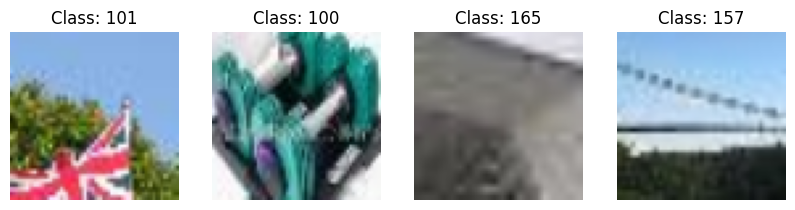

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Define data directories from Kaggle
train_dir = "/kaggle/input/tiny-imagenet/tiny-imagenet-200/train"
val_dir = "/kaggle/input/tiny-imagenet/tiny-imagenet-200/val"
test_dir = "/kaggle/input/tiny-imagenet/tiny-imagenet-200/test/images" 

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Tiny ImageNet has 200 classes
NUM_CLASSES = 200

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom Dataset class
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_val=False):  # Add is_val parameter
        self.root_dir = root_dir
        self.transform = transform
        self.is_val = is_val

        if not self.is_val:
            self.class_names = sorted(os.listdir(root_dir))
            self.image_paths = []
            self.labels = []

            for i, class_name in enumerate(self.class_names):
                class_dir = os.path.join(self.root_dir, class_name, 'images')
                for image_name in os.listdir(class_dir):
                    self.image_paths.append(os.path.join(class_dir, image_name))
                    self.labels.append(i)
        else:
            self.image_paths = sorted(
                [os.path.join(root_dir, 'images', img) for img in os.listdir(os.path.join(root_dir, 'images'))])
            self.val_labels = self._get_val_labels()  # Load validation labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if not self.is_val:
            label = self.labels[idx]
            return image, label
        else:
            label = self.val_labels[idx]
            return image, label

    def _get_val_labels(self):
        """
        Reads the validation labels from 'val_annotations.txt' and returns them
        as a list, ordered by image filename.
        """
        annotations_file = os.path.join(self.root_dir, 'val_annotations.txt')
        annotations = pd.read_csv(annotations_file, sep='\t', header=None, index_col=0)
        annotations.index = annotations.index.str.replace('.JPEG', '')  # Clean up filenames
        annotations = annotations.sort_index()  # Ensure correct order
        return annotations.iloc[:, 0].tolist()  # Return only the labels


# Load the datasets
train_dataset = TinyImageNetDataset(train_dir, transform=transform_train)
val_dataset = TinyImageNetDataset(val_dir, transform=transform_val, is_val=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


# Visualization function
def show_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
        plt.imshow(img)
        if not isinstance(labels, list):  # Check if labels is a list
            plt.title(f"Class: {labels[i]}")
        else:
            plt.title(f"Class: {labels[i]}")
        plt.axis('off')
    plt.show()

show_images(train_loader)

In [2]:
# Baseline CNN Model
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


# Target CNN Model (Inspired by Enhanced CNN and DenseNet concepts)
class TargetCNN(nn.Module):
    def __init__(self, num_classes):
        super(TargetCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # More layers
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1)) #Global Average Pooling
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.global_avg_pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        return x

# Instantiate the models
baseline_model = BaselineCNN(NUM_CLASSES).to(device)
target_model = TargetCNN(NUM_CLASSES).to(device)

print("Baseline Model Architecture:")
print(baseline_model)

print("\nTarget Model Architecture:")
print(target_model)

Baseline Model Architecture:
BaselineCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=200, bias=True)
)

Target Model Architecture:
TargetCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): Bat

In [ ]:
# Loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=0.001)
optimizer_target = optim.Adam(target_model.parameters(), lr=0.001)

# Training parameters
EPOCHS = 25
best_val_loss_baseline = float('inf')
best_val_loss_target = float('inf')


def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs, model_name):
    global best_val_loss_baseline, best_val_loss_target
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            # Convert labels if they are not integers
            if isinstance(labels, tuple):
                labels = torch.tensor([class_to_idx[l] for l in labels]).to(device)
            else:
                labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                if isinstance(labels, tuple):
                    labels = torch.tensor([class_to_idx[l] for l in labels]).to(device)
                else:
                    labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        if model_name == "Baseline" and avg_val_loss < best_val_loss_baseline:
            best_val_loss_baseline = avg_val_loss
            torch.save(model.state_dict(), "baseline_best.pth")
        elif model_name == "Target" and avg_val_loss < best_val_loss_target:
            best_val_loss_target = avg_val_loss
            torch.save(model.state_dict(), "target_best.pth")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Use dataloaders from our earlier definition
train_loader = dataloaders['train']
val_loader = dataloaders['val']

# Train both models
print("\nTraining Baseline Model:")
train_losses_baseline, val_losses_baseline, train_acc_baseline, val_acc_baseline = train_and_validate(
    baseline_model, train_loader, val_loader, optimizer_baseline, criterion, EPOCHS, "Baseline"
)

print("\nTraining Target Model:")
train_losses_target, val_losses_target, train_acc_target, val_acc_target = train_and_validate(
    target_model, train_loader, val_loader, optimizer_target, criterion, EPOCHS, "Target"
)



Training Baseline Model:
Epoch [1/25], Train Loss: 4.6248, Train Acc: 6.25%, Val Loss: 7.7877, Val Acc: 0.38%
Epoch [2/25], Train Loss: 4.5288, Train Acc: 8.28%, Val Loss: 7.5924, Val Acc: 2.59%
Epoch [3/25], Train Loss: 4.4328, Train Acc: 10.31%, Val Loss: 7.3971, Val Acc: 4.80%
Epoch [4/25], Train Loss: 4.3368, Train Acc: 12.34%, Val Loss: 7.2018, Val Acc: 7.01%
Epoch [5/25], Train Loss: 4.2408, Train Acc: 14.37%, Val Loss: 7.0065, Val Acc: 9.22%
Epoch [6/25], Train Loss: 4.1448, Train Acc: 16.40%, Val Loss: 6.8112, Val Acc: 11.43%
Epoch [7/25], Train Loss: 4.0488, Train Acc: 18.43%, Val Loss: 6.6159, Val Acc: 13.64%
Epoch [8/25], Train Loss: 3.9528, Train Acc: 20.46%, Val Loss: 6.4206, Val Acc: 15.85%
Epoch [9/25], Train Loss: 3.8568, Train Acc: 22.49%, Val Loss: 6.2253, Val Acc: 18.06%
Epoch [10/25], Train Loss: 3.7608, Train Acc: 24.52%, Val Loss: 6.0300, Val Acc: 20.27%
Epoch [11/25], Train Loss: 3.6648, Train Acc: 26.55%, Val Loss: 5.8347, Val Acc: 22.48%
Epoch [12/25], Train L

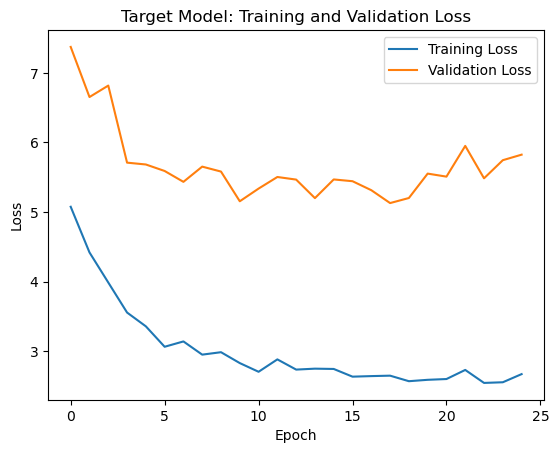

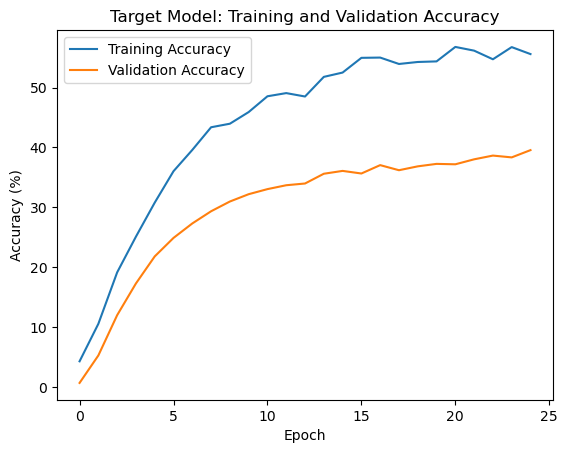

In [ ]:
# Plot training and validation loss curves for Target Model
plt.figure()
plt.plot(range(EPOCHS), train_losses_target, label='Training Loss')
plt.plot(range(EPOCHS), val_losses_target, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Target Model: Training and Validation Loss')
plt.show()

# Plot training and validation accuracy curves for Target Model
plt.figure()
plt.plot(range(EPOCHS), train_acc_target, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_target, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Target Model: Training and Validation Accuracy')
plt.show()